In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TinyML/TinyML Project

/content/drive/MyDrive/TinyML/TinyML Project


In [ ]:
%cd /content/drive/MyDrive/TinyML/TinyML Project/kws_test/Spoken-Keyword-Spotting/src

/content/drive/MyDrive/TinyML/TinyML Project/kws_test/Spoken-Keyword-Spotting/src


In [ ]:
!pip install PyAudio==0.2.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  ERROR: Failed building wheel for PyAudio
  Running setup.py clean for PyAudio
Failed to build PyAudio
    Running setup.py install for PyAudio ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-0wm45iki/pyaudio_ff8b13228a6a44ac9dd0addd2860417e/setup.py'"'"'; __file__='"'"'/tmp/pip-install-0wm45iki/pyaudio_ff8b13228a6a44ac9dd0addd2860417e/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-km3cyp3h/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.8/PyAudio Check the logs f

In [ ]:
!python stream_audio_edited.py

Traceback (most recent call last):
  File "stream_audio_edited.py", line 9, in <module>
    import pyaudio
ModuleNotFoundError: No module named 'pyaudio'


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model, load_model

In [ ]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [ ]:
path = 'kws_test/Spoken-Keyword-Spotting/models/student_2560_60ep.h5'

In [ ]:
model = load_model(path)

In [2]:
#improvisation since tf.data.dataset generators not working#
def rep_ds():
  files = []
  for cat in categories:
    files.append(selectRandomFileFromClass(cat, 5))

  ds = []
  for filename in files:
    transformed_data, _ = parse_fn(INPUT_DATA_PATH + filename, categories[className], parse_param=PARSE_PARAMS, scale=False)
    ds.append(transformed_data)
  return ds

In [ ]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model_1204_180ep_2dis2.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.representative_dataset = representative_dataset
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME

In [ ]:
open(tflite_model_name, "wb").write(tflite_model)
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

with open('compressed_model_1204_180_ep_2dis2.tflite', 'wb') as f:
   f.write(tflite_model)

File size: 771.051 Kilobytes


In [ ]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 99 40]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 31]
Output Type: <class 'numpy.float32'>


In [ ]:
!pip install scikit_optimize python_speech_features path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 9.0 MB/s 
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=0c67bcc4014f4f6906f2a487203d655575a634c1635711b1e293ecab60d83952
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python-speech-features


#Preprocess a single .wav file and extract the prediction from the compressed model

In [ ]:
PARSE_PARAMS = (0.025, 0.01, 40)
AUDIO_LENGTH = 16000
AUDIO_SR = 16000
INPUT_DATA_PATH = "kws_test/Spoken-Keyword-Spotting/input/speech_commands/train/"


In [ ]:
def parse_fn(filename, label, parse_param=PARSE_PARAMS, scale=False):
    """
    Calculates filterbank energies for a given file
    :param filename: File name
    :param label: Class label
    :param parse_param: Window parameters
    :param scale: Whether to normalize the filterbanks
    :return: Filterbanks, Label
    """

    wave = loadfile(filename)
    fbank = logMelFilterbank(wave, parse_param)
    if fbank.shape != (99,40):
        print("HEY FVANK")
        print (fbank.shape)
    if scale:
        fbank = normalize(fbank)

    return fbank, np.asarray(label, dtype=np.int32)

In [ ]:
from scipy.io import wavfile

def loadfile(filename):
    """
    Return a np array containing the wav
    :param filename: Filename of wav
    """

    _, wave = wavfile.read(filename)
    
    # Pad with noise if audio is short
    if len(wave) < AUDIO_LENGTH:
        silence_part = np.random.normal(0, 5, AUDIO_LENGTH - len(wave))
        wave = np.append(np.asarray(wave), silence_part)

    return np.array(wave, dtype=np.float32)

In [ ]:
from python_speech_features import logfbank

def logMelFilterbank(wave, parse_param=PARSE_PARAMS):
    """
    Computes the log Mel filterbanks
    :param wave: Audio as an array
    :param parse_param: Window Parameter
    :return: Filterbanks
    """

    fbank = logfbank(
        wave,
        samplerate=AUDIO_SR,
        winlen=float(parse_param[0]),
        winstep=float(parse_param[1]),
        highfreq=AUDIO_SR / 2,
        nfilt=int(parse_param[2]),
    )

    fbank = np.array(fbank, dtype=np.float32)

    return fbank

In [ ]:
def normalize(data):
    """
    Normalizes the data (z-score)
    :param data: Data to be normalized
    :return: Nomralized data
    """

    mean = np.mean(data, axis=0)
    sd = np.std(data, axis=0)

    # If Std Dev is 0
    if not sd:
        sd = 1e-7

    return (data - mean) / sd

In [ ]:
categories = {
    "stop": 0,
    "nine": 1,
    "off": 2,
    "four": 3,
    "right": 4,
    "eight": 5,
    "one": 6,
    "bird": 7,
    "dog": 8,
    "no": 9,
    "on": 10,
    "seven": 11,
    "cat": 12,
    "left": 13,
    "three": 14,
    "tree": 15,
    "bed": 16,
    "zero": 17,
    "happy": 18,
    "sheila": 19,
    "five": 20,
    "down": 21,
    "marvin": 22,
    "six": 23,
    "up": 24,
    "wow": 25,
    "house": 26,
    "go": 27,
    "yes": 28,
    "two": 29,
    "_background_noise_": 30,
}


inv_categories = {
    0: "stop",
    1: "nine",
    2: "off",
    3: "four",
    4: "right",
    5: "eight",
    6: "one",
    7: "bird",
    8: "dog",
    9: "no",
    10: "on",
    11: "seven",
    12: "cat",
    13: "left",
    14: "three",
    15: "tree",
    16: "bed",
    17: "zero",
    18: "happy",
    19: "sheila",
    20: "five",
    21: "down",
    22: "marvin",
    23: "six",
    24: "up",
    25: "wow",
    26: "house",
    27: "go",
    28: "yes",
    29: "two",
    30: "_background_noise_",
}

In [ ]:
import random

def selectRandomFileFromClass(className, numToRet):
  validation_files = open(INPUT_DATA_PATH + "validation_list.txt").read().splitlines()
  class_of_interest = []
  for n in range(len(validation_files)):
    if validation_files[n].startswith(className):
      class_of_interest.append(n)

  print("length of class choices: ", len(class_of_interest))
  random_choices = random.choices(class_of_interest, k=numToRet)
  return [validation_files[i] for i in random_choices]


def getAllFiles():
  validation_files = open(INPUT_DATA_PATH + "validation_list.txt").read().splitlines()
  print("length of all files: ", len(validation_files))
  return validation_files
  

In [ ]:
def getPredictionsTfLite(className, checkAgainst, numToRet):
  
  input_shape = input_details[0]['shape']
  #files = getAllFiles()
  files = selectRandomFileFromClass(className, numToRet)

  count = 0
  i = 0
  for filename in files:
    if i % 50 == 0: print('i: ', i)
    transformed_data, _ = parse_fn(INPUT_DATA_PATH + filename, categories[className], parse_param=PARSE_PARAMS, scale=False) #the label we pass here doesnt matter
    interpreter.set_tensor(input_details[0]['index'], np.reshape(transformed_data, (1, 99,40)))
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    pred = inv_categories[np.argmax(output_data)]
    #prob = output_data.max()
    if pred == checkAgainst:
      count += 1
    i += 1
    #print("We predict class ", pred.upper(), " with probability ", str(prob))
    #print("max: ", output_data.max())
  print("true marvins: ", count)

In [ ]:
getPredictionsTfLite("marvin", "marvin", 160)
#precision = marvins/(marvins + 170)

length of class choices:  160
i:  0
i:  50
i:  100
i:  150
true marvins:  41


In [ ]:
!ls

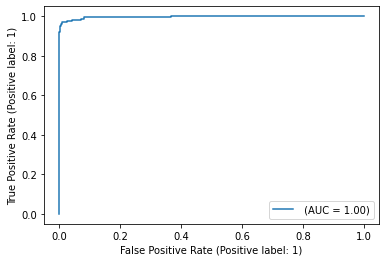

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
# X, y = make_classification(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=0)
# clf = SVC(random_state=0).fit(X_train, y_train)
# y_pred = clf.decision_function(X_test)
# RocCurveDisplay.from_predictions(y_test, y_pred)
# plt.show()

def plot_roc_curve():
    y_true = []
    with open("labels.txt") as f:
        for x in f.readlines():
            y_true.append(True if (x.strip() == "True") else False)
    y_pred = []
    with open("probs.txt") as f:
        for x in f.readlines():
            y_pred.append(float(x.strip()))
    display = RocCurveDisplay.from_predictions(y_true, y_pred, name="")
    
    plt.show()
def plot_pr_curve():
    #  y_true, y_pred = getPredictionsTfLite("marvin", "marvin", 160)
    y_true = []
    with open("labels.txt") as f:
        for x in f.readlines():
            y_true.append(bool(x.strip()))
    y_pred = []
    with open("probs.txt") as f:
        for x in f.readlines():
            y_pred.append(float(x.strip()))
    display = PrecisionRecallDisplay.from_predictions(y_true, y_pred, name="")
    display.ax_.set_title("Knowledge Distillation PR Curve")
    display.plot()
    plt.show()
plot_roc_curve()